In [1]:
# import spark sql and functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.master('local[16]').getOrCreate()

In [3]:
crime_data = spark.read.csv('data/combined_crime.csv', header=True, inferSchema=True)

In [4]:
expenditure_data = spark.read.csv('data/expenditure.csv', header=True, inferSchema=True)

In [5]:
# schema of the data
crime_data.printSchema()

root
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- population: string (nullable = true)
 |-- violent_crime: string (nullable = true)
 |-- murder_and_nonnegligent_manslaughter: string (nullable = true)
 |-- forcible_rape: string (nullable = true)
 |-- robbery: string (nullable = true)
 |-- aggravated_assault: string (nullable = true)
 |-- non_violent_crime: double (nullable = true)
 |-- property_crime: string (nullable = true)
 |-- burglary: string (nullable = true)
 |-- larceny_theft: string (nullable = true)
 |-- motor_vehicle_theft: string (nullable = true)



In [6]:
expenditure_data.printSchema()

root
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- education_services_exp: string (nullable = true)
 |-- public_welfare_exp: string (nullable = true)
 |-- hospital_exp: string (nullable = true)
 |-- health_exp: string (nullable = true)
 |-- police_protection_exp: string (nullable = true)
 |-- fire_protection_exp: integer (nullable = true)
 |-- corrections_exp: integer (nullable = true)
 |-- inspection_and_regulation: integer (nullable = true)
 |-- parks_and_recreation_exp: string (nullable = true)
 |-- housing_&_community_development_exp: string (nullable = true)
 |-- financial_administration_exp: integer (nullable = true)
 |-- judicial_and_legal_exp: integer (nullable = true)
 |-- general_public_buildings_exp: integer (nullable = true)
 |-- other_governmental_admin_exp: string (nullable = true)



In [7]:
# perform an inner join for city and state
crime_expenditure = crime_data.join(expenditure_data, ['city', 'state'], 'inner')

In [8]:
# new schema
crime_expenditure.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- year: string (nullable = true)
 |-- population: string (nullable = true)
 |-- violent_crime: string (nullable = true)
 |-- murder_and_nonnegligent_manslaughter: string (nullable = true)
 |-- forcible_rape: string (nullable = true)
 |-- robbery: string (nullable = true)
 |-- aggravated_assault: string (nullable = true)
 |-- non_violent_crime: double (nullable = true)
 |-- property_crime: string (nullable = true)
 |-- burglary: string (nullable = true)
 |-- larceny_theft: string (nullable = true)
 |-- motor_vehicle_theft: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- education_services_exp: string (nullable = true)
 |-- public_welfare_exp: string (nullable = true)
 |-- hospital_exp: string (nullable = true)
 |-- health_exp: string (nullable = true)
 |-- police_protection_exp: string (nullable = true)
 |-- fire_protection_exp: integer (nullable = true)
 |-- corrections_exp: integer (nul

In [9]:
# head of the data
crime_expenditure.show(5)

+---------+-----+----+----------+-------------+------------------------------------+-------------+-------+------------------+-----------------+--------------+--------+-------------+-------------------+----+----------------------+------------------+------------+----------+---------------------+-------------------+---------------+-------------------------+------------------------+-----------------------------------+----------------------------+----------------------+----------------------------+----------------------------+
|     city|state|year|population|violent_crime|murder_and_nonnegligent_manslaughter|forcible_rape|robbery|aggravated_assault|non_violent_crime|property_crime|burglary|larceny_theft|motor_vehicle_theft|year|education_services_exp|public_welfare_exp|hospital_exp|health_exp|police_protection_exp|fire_protection_exp|corrections_exp|inspection_and_regulation|parks_and_recreation_exp|housing_&_community_development_exp|financial_administration_exp|judicial_and_legal_exp|gen

In [10]:
# shape of the data
print((crime_expenditure.count(), len(crime_expenditure.columns)))

(520, 29)


In [11]:
# group by state and city and aggregate the data
crime_expenditure = crime_expenditure.groupBy('state', 'city').agg(
    sum('population').alias('population'),
    sum('violent_crime').alias('violent_crime'))
crime_expenditure.show(5)

+-----+-----------+------------+-------------+
|state|       city|  population|violent_crime|
+-----+-----------+------------+-------------+
|   AL| Montgomery| 1.1277144E7|      59360.0|
|   AR|Little Rock| 1.5792096E7|     232792.0|
|   AZ|    Phoenix|1.13044048E8|     731408.0|
|   AZ|       Mesa| 3.4161112E7|     136792.0|
|   AK|  Anchorage|  2.370752E7|     239648.0|
+-----+-----------+------------+-------------+
only showing top 5 rows



In [14]:
# check highest crime rate
crime_expenditure.orderBy(desc('violent_crime')).show(10)

+-----+-----------+------------+-------------+
|state|       city|  population|violent_crime|
+-----+-----------+------------+-------------+
|   AZ|    Phoenix|1.13044048E8|     731408.0|
|   AK|  Anchorage|  2.370752E7|     239648.0|
|   AR|Little Rock| 1.5792096E7|     232792.0|
|   AZ|     Tucson| 3.0042296E7|     214888.0|
|   AZ|       Mesa| 3.4161112E7|     136792.0|
|   AL| Birmingham|   6797384.0|     105320.0|
|   AL| Montgomery| 1.1277144E7|      59360.0|
|   AK|  Fairbanks|   2325536.0|      14384.0|
+-----+-----------+------------+-------------+



In [15]:
#make a new column called crime by population
crime_expenditure = crime_expenditure.withColumn('crime_by_population', crime_expenditure.violent_crime/crime_expenditure.population)
crime_expenditure.show(5)

+-----+-----------+------------+-------------+--------------------+
|state|       city|  population|violent_crime| crime_by_population|
+-----+-----------+------------+-------------+--------------------+
|   AL| Montgomery| 1.1277144E7|      59360.0|0.005263744082721654|
|   AR|Little Rock| 1.5792096E7|     232792.0|0.014741045140556389|
|   AZ|    Phoenix|1.13044048E8|     731408.0|0.006470115082927...|
|   AZ|       Mesa| 3.4161112E7|     136792.0|0.004004319297334349|
|   AK|  Anchorage|  2.370752E7|     239648.0|0.010108522527873013|
+-----+-----------+------------+-------------+--------------------+
only showing top 5 rows



In [16]:
# check highest crime rate
crime_expenditure.orderBy(desc('crime_by_population')).show(10)

+-----+-----------+------------+-------------+--------------------+
|state|       city|  population|violent_crime| crime_by_population|
+-----+-----------+------------+-------------+--------------------+
|   AL| Birmingham|   6797384.0|     105320.0|0.015494196002462124|
|   AR|Little Rock| 1.5792096E7|     232792.0|0.014741045140556389|
|   AK|  Anchorage|  2.370752E7|     239648.0|0.010108522527873013|
|   AZ|     Tucson| 3.0042296E7|     214888.0|0.007152848770280407|
|   AZ|    Phoenix|1.13044048E8|     731408.0|0.006470115082927...|
|   AK|  Fairbanks|   2325536.0|      14384.0|0.006185240735899164|
|   AL| Montgomery| 1.1277144E7|      59360.0|0.005263744082721654|
|   AZ|       Mesa| 3.4161112E7|     136792.0|0.004004319297334349|
+-----+-----------+------------+-------------+--------------------+



<AxesSubplot:xlabel='city'>

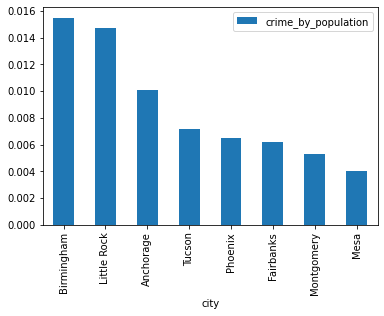

In [17]:
# graph top 10 crime rate
crime_expenditure.orderBy(desc('crime_by_population')).limit(10).toPandas().plot.bar(x='city', y='crime_by_population')

<AxesSubplot:xlabel='city'>

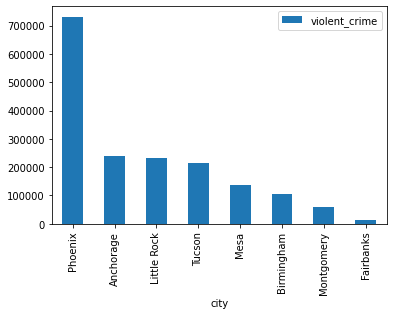

In [18]:
# graph top 10 overall crime
crime_expenditure.orderBy(desc('violent_crime')).limit(10).toPandas().plot.bar(x='city', y='violent_crime')